Predicting Food Delivery Time using Regression Models to Estimate ETA Based on Distance, Traffic, Weather, and Other Features

In [179]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.metrics import mean_absolute_error

In [180]:
# import dataset
df = pd.read_csv("Food_Delivery_Times.csv")

Data Understanding

In [181]:
# check top 5 rows of dataset
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [182]:
# drop some irrelevant features
df.drop("Order_ID", axis=1, inplace=True)

In [183]:
# check shape of dataset
df.shape

(1000, 8)

In [186]:
# check dataset have null values or not
df.isnull().sum()

,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


In [185]:
# check dataset have duplicate rows or not
df.duplicated().sum()

np.int64(0)

In [190]:
# check data types of all features
df.dtypes

,0
Distance_km,float64
Weather,object
Traffic_Level,object
Time_of_Day,object
Vehicle_Type,object
Preparation_Time_min,int64
Courier_Experience_yrs,float64
Delivery_Time_min,int64


In [188]:
# some mathematical calculations on numerical features
df.describe()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,970.000000,1000.000000
mean,10.059970,16.982000,4.579381,56.732000
std,5.696656,7.204553,2.914394,22.070915
min,0.590000,5.000000,0.000000,8.000000
25%,5.105000,11.000000,2.000000,41.000000
50%,10.190000,17.000000,5.000000,55.500000
75%,15.017500,23.000000,7.000000,71.000000
max,19.990000,29.000000,9.000000,153.000000


In [191]:
# value counts of categorical features
cat_cols = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

for col in cat_cols:
    print(df[col].value_counts())
    print()

Weather
Clear    470
Rainy    204
Foggy    103
Snowy     97
Windy     96
Name: count, dtype: int64

Traffic_Level
Medium    390
Low       383
High      197
Name: count, dtype: int64

Time_of_Day
Morning      308
Evening      293
Afternoon    284
Night         85
Name: count, dtype: int64

Vehicle_Type
Bike       503
Scooter    302
Car        195
Name: count, dtype: int64



Data Preprocessing

In [195]:
# fill missing values of categorical features with thier mode
df["Weather"] = df["Weather"].fillna(df["Weather"].mode()[0])
df["Traffic_Level"] = df["Traffic_Level"].fillna(df["Traffic_Level"].mode()[0])
df["Time_of_Day"] = df["Time_of_Day"].fillna(df["Time_of_Day"].mode()[0])

# fill missing values of numerical column with their mean
df["Courier_Experience_yrs"] = df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].mean())

In [196]:
# type casting numerical data
df["Distance_km"] = df["Distance_km"].astype("float32")
df["Preparation_Time_min"] = df["Preparation_Time_min"].astype("int32")
df["Courier_Experience_yrs"] = df["Courier_Experience_yrs"].astype("float32")
df["Delivery_Time_min"] = df["Delivery_Time_min"].astype("int32")

Data Visualization

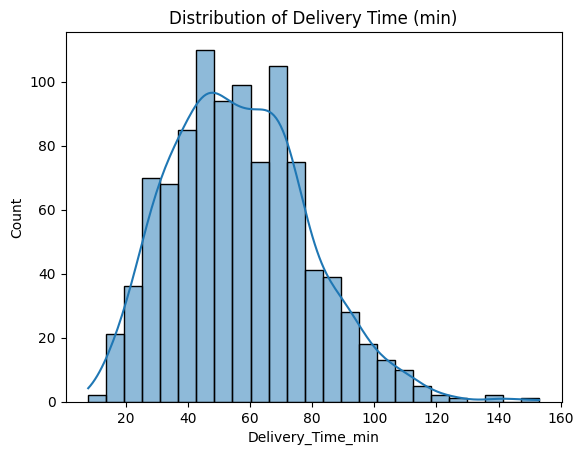

In [197]:
# distribution of delivery time
sns.histplot(df["Delivery_Time_min"], kde=True)
plt.title("Distribution of Delivery Time (min)")
plt.show()

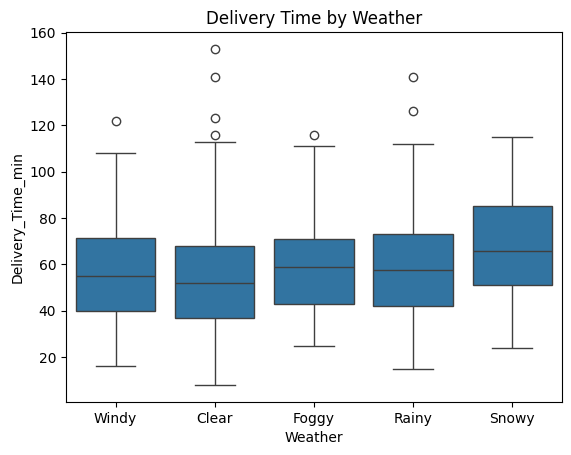

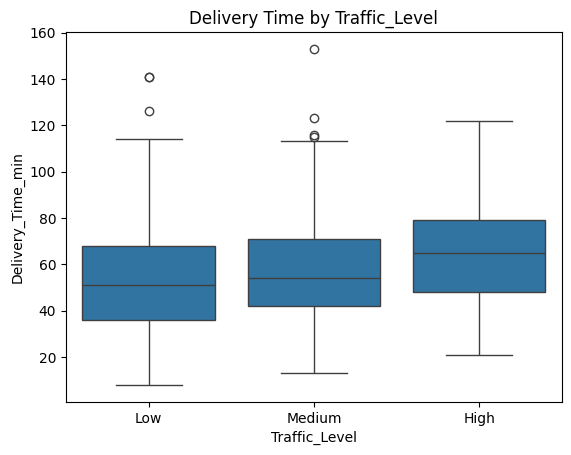

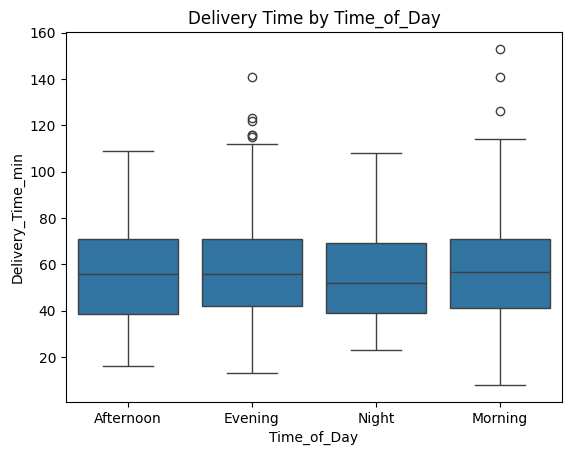

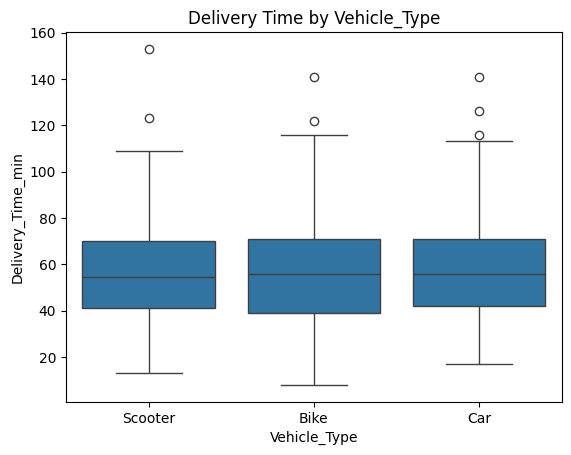

In [198]:
# boxplots for categorical features vs delivery time
for col in cat_cols:
    sns.boxplot(x=df[col], y=df['Delivery_Time_min'])
    plt.title(f'Delivery Time by {col}')
    plt.show()
    print()

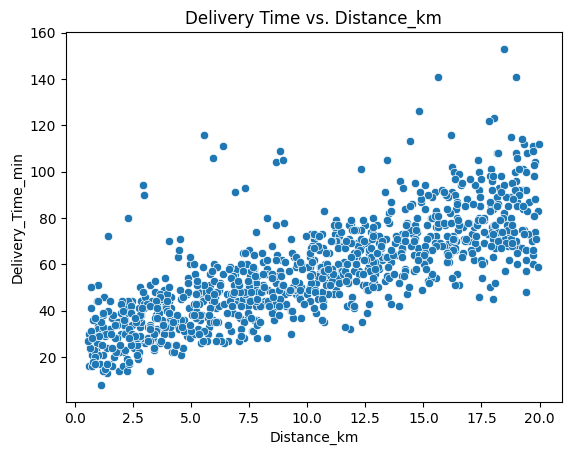

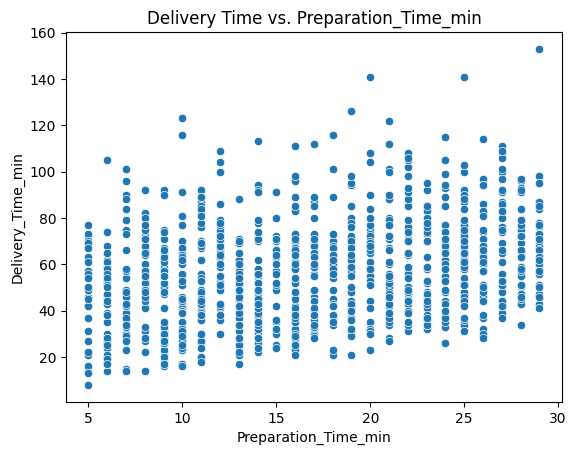

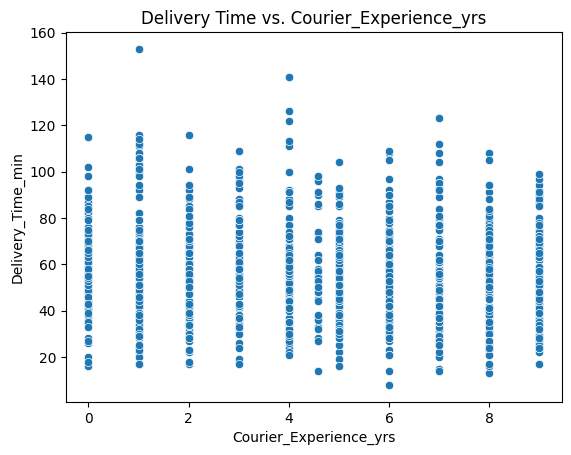

In [199]:
# boxplots for numerical features vs delivery time
num_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

for col in num_cols:
    sns.scatterplot(x=df[col], y=df['Delivery_Time_min'])
    plt.title(f'Delivery Time vs. {col}')
    plt.show()
    print()

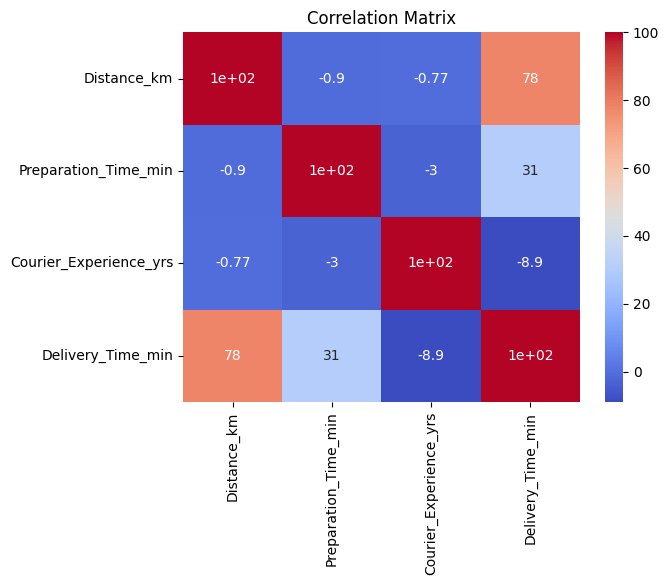

In [200]:
# heatmap of corelation
sns.heatmap(df.drop(cat_cols, axis=1).corr()*100, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Preparing Data For Training And Validation

In [201]:
# separating dependent and independent variable
x = df.iloc[:,:-1]
y = df["Delivery_Time_min"]

In [203]:
# splitting data for training and validation
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [205]:
# making column transformer for pipeline
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),  cat_cols),
], remainder="passthrough")

Model Selection Using Cross Validation Score

In [206]:
# making dictionary for multiple algorithms
obj = {
    "LinearRegression" : LinearRegression(),
    "knn" : KNeighborsRegressor(),
    "svm" : SVR(),
    "DecisionTree" : DecisionTreeRegressor(random_state=42),
    "RandomForest" : RandomForestRegressor(random_state=42)
}

In [207]:
# check cross validation score for a quick estimate
for name, model in obj.items():

    # making pipeline
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("sc", StandardScaler()),
        ("model", model)
    ])

    # calculating cross validation score
    mean_score = cross_val_score(pipe, x, y, cv=5, scoring="r2").mean()*100
    print(f'{name}: {mean_score}')

LinearRegression: 76.85255980178323
knn: 39.63957125164489
svm: 54.14906219234199
DecisionTree: 36.0188625555222
RandomForest: 71.96997529411314


LinearRegression and RandomForest Gives Higher R2 Score, Now Train And Test Them With Their Best Hyperparameters

Hyperparameter Tuning of RandomForest

In [129]:
# define objective function
def objective(trial):

    # creating sample space for hyperparameter tuning
    n_estimators = trial.suggest_int("n_estimators", 200, 1200, step=50)
    max_depth = trial.suggest_int("max_depth", 4, 40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 8)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = RandomForestRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        random_state = 42,
        n_jobs = -1
    )

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # evaluating with cross validation score
    scores = cross_val_score(pipe, x, y, cv=3, scoring="neg_mean_absolute_error")
    return scores.mean()

In [130]:
# finding best hyper Parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100)

[I 2025-07-15 11:09:02,891] A new study created in memory with name: no-name-7b7b7dff-4bfe-4223-9425-4bff8026db3e
[I 2025-07-15 11:09:12,327] Trial 0 finished with value: -8.90749919582583 and parameters: {'n_estimators': 1200, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: -8.90749919582583.
[I 2025-07-15 11:09:16,305] Trial 1 finished with value: -8.305175925804818 and parameters: {'n_estimators': 500, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: -8.305175925804818.
[I 2025-07-15 11:09:22,386] Trial 2 finished with value: -7.5638029317766495 and parameters: {'n_estimators': 500, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: -7.5638029317766495.
[I 2025-07-15 11:09:26,545] Trial 3 finished with value: -9.22102727143669 and parameters: {'n_estimators': 550, 'max_depth': 11, 'min

In [209]:
# best hyper parameters and value of model
print(f'best parameters : {study.best_params}')
print(f'best value : {study.best_value}')

best parameters : {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}
best value : -7.555952265356179


Training RandomForestRegresson Model With Their Best Hyperparameters

In [211]:
rf_model = RandomForestRegressor(
    n_estimators = 450,
    max_depth = 10,
    min_samples_split = 5,
    min_samples_leaf = 3,
    max_features = None,
    random_state = 42
)

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

rf_pipe.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Weather', 'Traffic_Level',
                                                   'Time_of_Day',
                                                   'Vehicle_Type'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, max_features=None,
                                       min_samples_leaf=3, min_samples_split=5,
                                       n_estimators=450, random_state=42))])

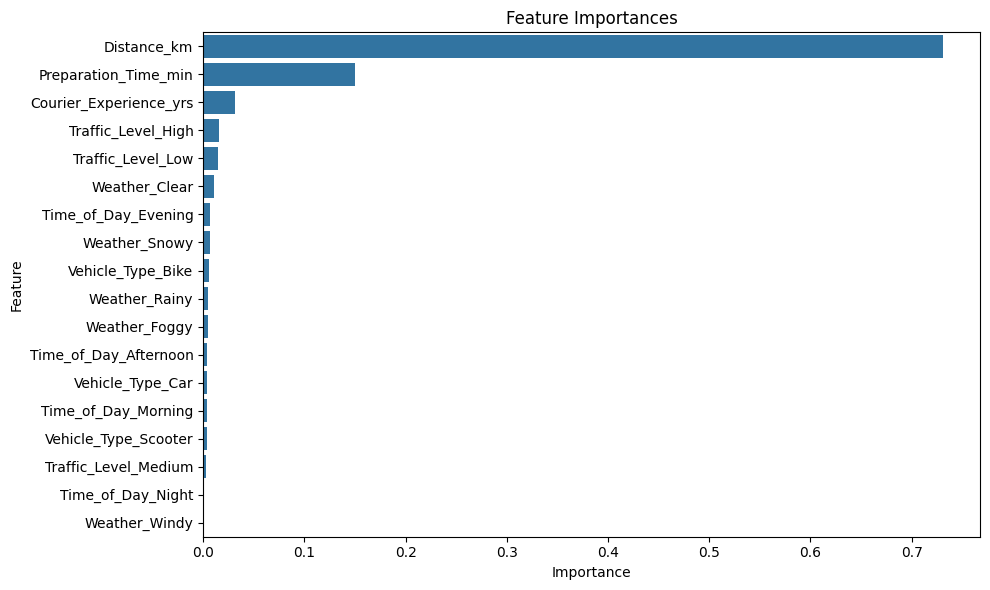

In [219]:
# visualizing feature importance of random forest

# extract the trained random forest model
rf_model = rf_pipe.named_steps["model"]

#   get ohe feature names
ohe = rf_pipe.named_steps["preprocessor"].named_transformers_["ohe"]
ohe_features = ohe.get_feature_names_out(cat_cols)

# get numerical features names
num_features = [col for col in xtrain.columns if col not in cat_cols]

# combine all feature names
feature_names = list(ohe_features) + num_features

# get feature importances
importances = rf_model.feature_importances_

# create DataFrame and sort by feature importance
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

RandomForestRegressor model Evaluation

In [213]:
# evaluating model using mean absolute error and r2_score
ypre = rf_pipe.predict(xtest)

mae = mean_absolute_error(ytest, ypre)
r2_score = rf_pipe.score(xtest, ytest)*100 # converting r2_score into percentage

print(f'R2 score : {r2_score}')
print(f'mean absolute error : {mae}')

R2 score : 79.65219718540276
mean absolute error : 6.605335873846183


Training LinearRegression Model

In [215]:
lr_model = LinearRegression()

lr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("sc", StandardScaler()),
    ("model", lr_model)
])

lr_pipe.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Weather', 'Traffic_Level',
                                                   'Time_of_Day',
                                                   'Vehicle_Type'])])),
                ('sc', StandardScaler()), ('model', LinearRegression())])

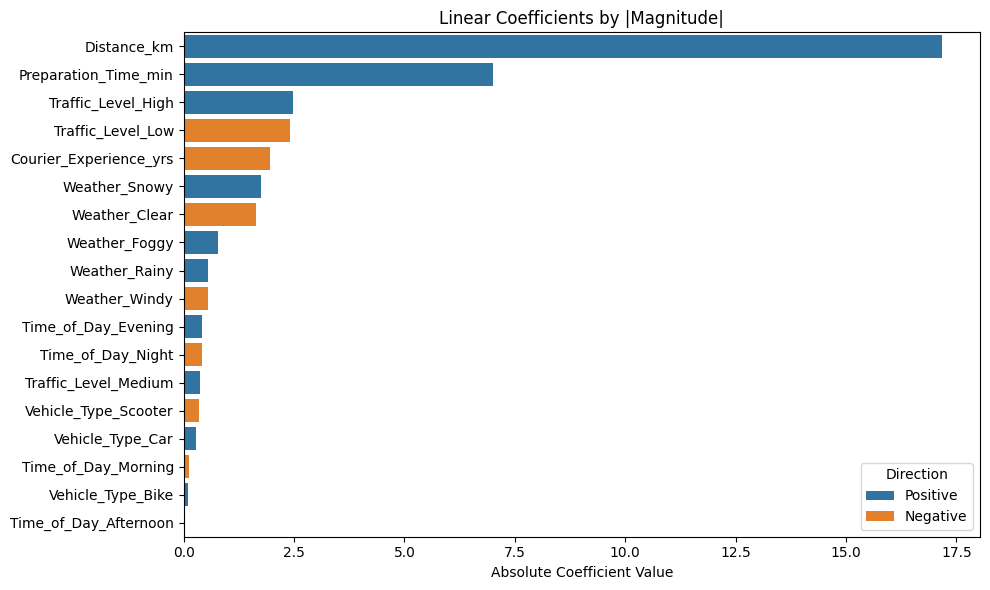

In [218]:
# visualizing feature importance of linear regression

# extract the trained linear regression model
lr_model = lr_pipe.named_steps["model"]

# get feature names coming out of the column transformer
preprocessor = lr_pipe.named_steps["preprocessor"]

# get ohe features names
ohe = preprocessor.named_transformers_["ohe"]
ohe_features = ohe.get_feature_names_out(cat_cols)

# get numerical features
num_features = [col for col in xtrain.columns if col not in cat_cols]

# cmbine to get the final feature list in the same order seen by the model
feature_names = list(ohe_features) + num_features

# pull coefficients and turn them into an “importance”
coefficients = lr_model.coef_
importance = np.abs(coefficients)

# create a dataframe and sort by feature importance
coef_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients,
        "Importance": importance,
    })
    .sort_values("Importance", ascending=False)
)

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df,
    x="Importance",
    y="Feature",
    hue=np.sign(coef_df["Coefficient"]).map({1: "Positive", -1: "Negative"}),
    dodge=False
)
plt.title(f"Linear Coefficients by |Magnitude|")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("")
plt.legend(title="Direction", loc="lower right")
plt.tight_layout()
plt.show()

LinearRegression Model Evaluation

In [216]:
# evaluating model using mean absolute error and r2_score
ypre = lr_pipe.predict(xtest)

mae = mean_absolute_error(ytest, ypre)
r2_score = lr_pipe.score(xtest, ytest)*100 # converting r2_score into percentage

print(f'R2 score : {r2_score}')
print(f'mean absolute error : {mae}')

R2 score : 82.63176894235802
mean absolute error : 5.899386915976794


Result - LinearRegression Performed Better Than Other Algorithms To Predict Food Delivery Time.